## **PROFILE**
NAMA : ECHA APRILIYANTO \
DOMISILI : KABUPATEN SLEMAN \
TAHUN BERGABUNG : 2022 \
PROFILE DICODING : https://www.dicoding.com/users/echa_apriliyanto_z/academies


## DATASET SPLIT

In [26]:
import os

if not os.path.exists('/content/submission'):
  os.makedirs('/content/submission')

In [27]:
!wget --no-check-certificate \
  https://github.com/dicodingacademy/assets/releases/download/release/rockpaperscissors.zip \
  -O /content/submission/rockpaperscissors.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [28]:
import zipfile

zip_path = '/content/submission/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(zip_path, 'r')
zip_ref.extractall('/content/submission')
zip_ref.close()

FileNotFoundError: [Errno 2] No such file or directory: '/content/submission/rockpaperscissors.zip'

In [25]:
import shutil
import random

classes = ['rock', 'paper', 'scissors']
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']

base_dir = '/content/submission/rockpaperscissors'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

for class_name in classes:
  for folder_name in [train_dir, val_dir]:
    class_folder_path = os.path.join(folder_name, class_name)
    if not os.path.exists(class_folder_path):
      os.makedirs(class_folder_path)

def split_data(class_name):
  class_path = os.path.join(base_dir, class_name)
  imgs_list = [filename for filename in os.listdir(class_path) if os.path.splitext(filename)[-1].lower() in image_extensions]

  random.seed(42)
  random.shuffle(imgs_list)

  val_size = int(len(imgs_list) * 0.4)
  train_size = len(imgs_list) - val_size

  for i, f in enumerate(imgs_list):
        if i < train_size:
            dest_folder = os.path.join(train_dir, class_name)
        else:
            dest_folder = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(class_path, f), os.path.join(dest_folder, f))

for class_name in classes:
  split_data(class_name)


FileNotFoundError: [WinError 3] The system cannot find the path specified: './content/submission/rockpaperscissors\\rock'

In [187]:
train_total = 0
val_total = 0

for class_name in classes:
  train_total += len(os.listdir(os.path.join(base_dir, 'train', class_name)))
  val_total += len(os.listdir(os.path.join(base_dir, 'val', class_name)))

print(f'Training data: {train_total}')
print(f'Validation data: {val_total}')

Training data: 1314
Validation data: 874


In [188]:
common_images = []

for class_name in classes:
    train_images = set(os.listdir(os.path.join(train_dir, class_name)))
    val_images = set(os.listdir(os.path.join(val_dir, class_name)))

    common = train_images.intersection(val_images)
    if common:
        common_images.extend([os.path.join(class_name, img) for img in common])

print(f'Images existing in both train and validation folders: {common_images}')
print(f'Total number of common images: {len(common_images)}')

Images existing in both train and validation folders: []
Total number of common images: 0


## CNN MODEL

In [189]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [190]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
    )

val_datagen = ImageDataGenerator(rescale=1./255)

In [191]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        batch_size=batch_size,
        seed=42,
        class_mode='categorical',
        color_mode='rgb',
        target_size=(150,150)
        )

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        batch_size=batch_size,
        seed=42,
        class_mode='categorical',
        color_mode='rgb',
        target_size=(150,150)
        )

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


In [192]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.activations import relu, softmax

model = Sequential([
    Conv2D(32, (3, 3), activation=relu, input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation=relu),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation=relu),
    MaxPooling2D(2, 2),
    Conv2D(256, (3, 3), activation=relu),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(624, activation=relu),
    Dense(128, activation=relu),
    Dense(3, activation=softmax)
    ])

In [193]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_93 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_93 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_94 (Conv2D)          (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_94 (MaxPooli  (None, 36, 36, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_95 (Conv2D)          (None, 34, 34, 128)       36992     
                                                                 
 max_pooling2d_95 (MaxPooli  (None, 17, 17, 128)     

In [194]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.RMSprop(),
              metrics=['accuracy'])

In [195]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import time

callbacks = [
    ModelCheckpoint(filepath='/content/submission/best_model.keras', monitor='val_accuracy', save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, min_lr=1e-5)
    ]

start_time = time.time()

history = model.fit(
    train_generator,
    steps_per_epoch=22,
    epochs=40,
    validation_data=validation_generator,
    validation_steps=3,
    callbacks=callbacks
    )

end_time = time.time()

training_time_seconds = end_time - start_time
training_time_minutes = training_time_seconds / 60

print(f"Total training time: {training_time_minutes:.2f} minutes")

Epoch 1/40
22/22 [==============================] - 44s 2s/step - loss: 1.1302 - accuracy: 0.3324 - val_loss: 1.1242 - val_accuracy: 0.2917 - lr: 0.0010
Epoch 2/40
22/22 [==============================] - 39s 2s/step - loss: 1.1011 - accuracy: 0.3409 - val_loss: 1.0784 - val_accuracy: 0.5104 - lr: 0.0010
Epoch 3/40
22/22 [==============================] - 37s 2s/step - loss: 1.0856 - accuracy: 0.4169 - val_loss: 1.0375 - val_accuracy: 0.5417 - lr: 0.0010
Epoch 4/40
22/22 [==============================] - 38s 2s/step - loss: 1.0630 - accuracy: 0.4588 - val_loss: 0.8052 - val_accuracy: 0.7396 - lr: 0.0010
Epoch 5/40
22/22 [==============================] - 36s 2s/step - loss: 1.0168 - accuracy: 0.5816 - val_loss: 0.6702 - val_accuracy: 0.8021 - lr: 0.0010
Epoch 6/40
22/22 [==============================] - 34s 2s/step - loss: 0.7621 - accuracy: 0.6558 - val_loss: 0.3294 - val_accuracy: 0.9479 - lr: 0.0010
Epoch 7/40
22/22 [==============================] - 36s 2s/step - loss: 0.7165 - a

## MODEL EVALUATION

In [197]:
results = model.evaluate(train_generator, batch_size=batch_size)
print('Model Performance on Training Data')
print('Accuracy: {:.2f}%'.format(results[1]*100))
print('Loss: {:.4f}'.format(results[0]))

42/42 [==============================] - 26s 606ms/step - loss: 0.0805 - accuracy: 0.9673
Model Performance on Training Data
Accuracy: 96.73%
Loss: 0.0805


In [198]:
results = model.evaluate(validation_generator, batch_size=batch_size)
print('Model Performance on Validation Data')
print('Accuracy: {:.2f}%'.format(results[1]*100))
print('Loss: {:.4f}'.format(results[0]))

28/28 [==============================] - 12s 420ms/step - loss: 0.0276 - accuracy: 0.9897
Model Performance on Validation Data
Accuracy: 98.97%
Loss: 0.0276


## PLOT

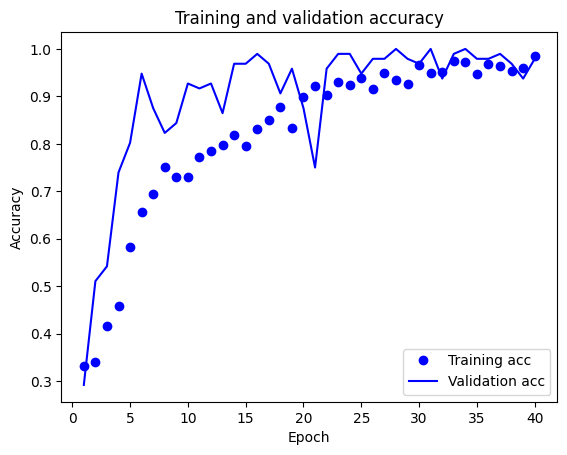

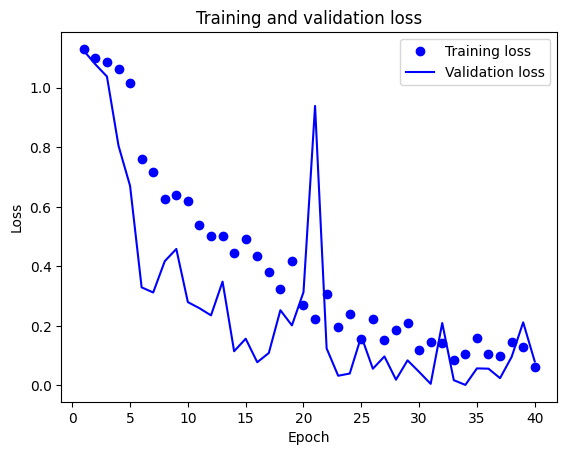

In [199]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


## MODEL PREDICTION TEST

Saving WhatsApp_Image_2024-06-23_at_19.29.12_e87eb0e3-transformed.png to WhatsApp_Image_2024-06-23_at_19.29.12_e87eb0e3-transformed (5).png


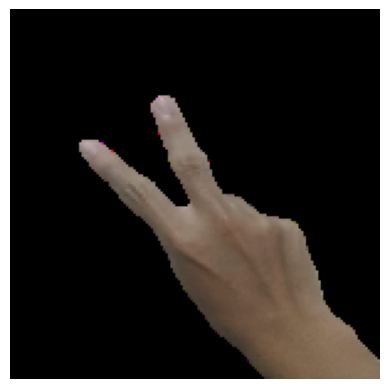

1/1 [==============================] - 0s 35ms/step

The image is detected as: Scissors

   Class  Probability
   Paper     0.000001
    Rock     0.000000
Scissors     1.000000 



In [207]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from google.colab import files

def preprocess_image(image_upload, target_size=(150, 150)):
    img = image.load_img(image_upload, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img, img_array

def predict_image(img_array, model):
    predictions = model.predict(img_array)[0]
    labels = ['Paper', 'Rock', 'Scissors']
    predicted_label = labels[np.argmax(predictions)]

    df = pd.DataFrame({
        'Class': labels,
        'Probability': predictions
        })

    return predicted_label, df

uploaded = files.upload()

for file_name in uploaded.keys():
    img_path = file_name
    img, img_array = preprocess_image(img_path)

    plt.imshow(img)
    plt.axis('off')
    plt.show()

    label, df = predict_image(img_array, model)

    print(f"\nThe image is detected as: {label}\n")
    print(df.to_string(index=False, float_format="{:.6f}".format), "\n")